# Implementation of collaborative filtering.

Two main approaches are used:
* Item-based;
* User-based.

## Imports

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import typing as tp

from io import BytesIO
from PIL import Image
import requests
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix

In [2]:
interactions = pd.read_csv("../data/BX-Book-Ratings.csv", sep=";", encoding="unicode-escape")
books = pd.read_csv("../data/BX-Books.csv", low_memory=False)
users = pd.read_csv("../data/BX-Users.csv", sep=";", encoding="unicode-escape")

Merge tables, so that it'll be possible to get item name and image url of item to view it later.

In [3]:
interactions = (
    interactions
    .merge(
        books[["ISBN", "Book-Title", "Image-URL-M"]],
        how="left",
        on="ISBN"
    )
)

Rename columns for convenience.

In [4]:
interactions = interactions.rename(
    columns={
        "User-ID": "user_id",
        "ISBN": "item_id",
        "Book-Rating": "score",
        "Book-Title": "item_name",
        "Image-URL-M": "image_url"
    }
)

Preprocess interactions.

In [5]:
interactions = interactions[interactions["item_name"].notna()]
interactions = interactions[interactions["score"] > 0]
le = LabelEncoder()
interactions["item_id"] = le.fit_transform(interactions["item_id"])
interactions["user_id"] = le.fit_transform(interactions["user_id"])

In [6]:
interactions = (
    interactions
    .groupby(["user_id", "item_id"])
    .agg({
        "score": "sum",
        "item_name": "first",
        "image_url": "first"
    })
    .reset_index()
)

## Utils

Some functions for viewing results.

In [21]:
# headers are needed to get 200 from request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36"
}

def chunks(l, n):
    """Generator that returns chunks."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(
    product_ids: tp.List[int],
    content_dict: tp.Dict[int, tp.Dict[str, int]],
    measure: tp.List[float] = None,
    top_n: int = 5
) -> None:
    """Renders multiple images."""
    picture_urls = [content_dict[i]["image_url"] for i in product_ids]
    cnt = 0
    for _, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i, headers=headers)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}\n{}...".format(np.round(measure[cnt], 4), content_dict[product_ids[cnt]]["name"][:30]))
                cnt += 1
            else:
                a.title.set_text(content_dict[product_ids[cnt]]["name"])
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

## Model

In [25]:
class Colloborative():
    def __init__(
        self, 
        interactions: pd.DataFrame
    ) -> None:
        self.content_dict = {}
        self.interactions = interactions

        # Fill dict with content
        for i, j, k in self.interactions[["item_id", "item_name", "image_url"]].drop_duplicates().values:
            self.content_dict[int(i)] = {
                "name": j,
                "image_url": k
            }

        # Create matrix in COO format
        self.coo_rates: coo_matrix = coo_matrix(
            (
                self.interactions["score"],
                (self.interactions["user_id"], self.interactions["item_id"])
            ),
            shape=(len(set(self.interactions["user_id"])), len(set(self.interactions["item_id"])))
        )

    def user_based(self, idx: int) -> None:
        """Get adjusted user-based recommendations."""
        mask = (self.coo_rates.getrow(idx).toarray()[0] > 0)

        # Get watched items
        watched_items = np.where(mask == True)[0]
        # Convert to CSR format
        csr_rates = self.coo_rates.tocsr()

        corating_matrix = csr_rates[:, watched_items].toarray()
        mean_user_rates = corating_matrix.mean(axis=1).reshape(-1, 1)

        target_user_rates = corating_matrix[idx].reshape(1, -1)
        target_user_mean_rate = target_user_rates.mean()

        # Compute similarity
        sim = cosine_similarity(
            np.array(target_user_rates),
            np.array(corating_matrix) 
        )
        nonzero_sim_user_ids = np.array(sim[0].nonzero()).flatten()

        modified_rates = csr_rates[nonzero_sim_user_ids] - mean_user_rates[nonzero_sim_user_ids]

        rates = np.array(sim[0][nonzero_sim_user_ids] * modified_rates).flatten()
        rates /= np.sum(np.abs(sim[0]))
        rates += target_user_mean_rate

        # Filter viewed items
        rates[watched_items] = 0

        top_recs = rates.argsort()[-10:][::-1]
        measure = sorted(rates)[-10:][::-1]
        self.get_rec(watched_items, top_recs, measure)

    def cosine_item_based(self, idx: int) -> None:
        """Get item-based recommendations with cosine similarity."""
        mask = (self.coo_rates.getcol(idx).toarray() > 0).flatten()

        # Get users who rated target item
        row_ids_with_rating = np.where(mask == True)[0]

        csc_rates = self.coo_rates.tocsc()

        rows_with_rating = csc_rates[row_ids_with_rating].toarray()

        target_item_rates = rows_with_rating[:, idx].reshape(1, -1)

        sim = cosine_similarity(
            np.array(target_item_rates),
            np.array(rows_with_rating.T)
        ).T

        rates = rows_with_rating.T * sim
        rates = np.array(np.sum(rates, axis=1)).flatten()
        rates /= np.abs(sim).sum()

        top_recs = np.array(rates).flatten().argsort()[-10:][::-1]
        measure = sorted(np.array(rates).flatten())[-10:][::-1]
        self.get_rec([idx], top_recs, measure)
        
    def adjusted_cosine_item_based(self, idx: int) -> None:
        """Get item-based recommendations with adjusted cosine similarity."""
        mask = (self.coo_rates.getcol(idx).toarray() > 0).flatten()

        # Get users who rated target item 
        users_who_rated_target = np.where(mask == True)[0]
        csc_rates = self.coo_rates.tocsc()

        corating_matrix = csc_rates[users_who_rated_target].toarray()

        # Compute mean item ratings over users
        mean_item_rates = corating_matrix.mean(axis=0)

        if users_who_rated_target.shape[0] == 1:
            modified_rates = corating_matrix
        else:
            modified_rates = corating_matrix - mean_item_rates
        target_item_rates = corating_matrix[:, idx].reshape(1, -1)

        sim = cosine_similarity(
            np.array(target_item_rates),
            np.array(corating_matrix.T)
        ).T

        rates = modified_rates.T * sim
        rates = np.array(np.sum(rates, axis=1)).flatten()
        rates /= np.abs(sim).sum()
        rates += mean_item_rates

        top_recs = np.array(rates).flatten().argsort()[-10:][::-1]
        measure = sorted(np.array(rates).flatten())[-10:][::-1]
        self.get_rec([idx], top_recs, measure)

    def get_rec(
        self,
        watched: tp.List[int],
        recs: tp.List[int],
        measure: tp.List[float]
    ) -> None:
        print("For these items:")
        rec_imaging(watched, self.content_dict)
        print("Such recommendations:")
        rec_imaging(recs, self.content_dict, measure)

In [26]:
model = Colloborative(interactions)

## Check recommendations

### User-based

For these items:


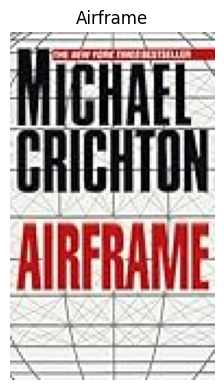

Such recommendations:


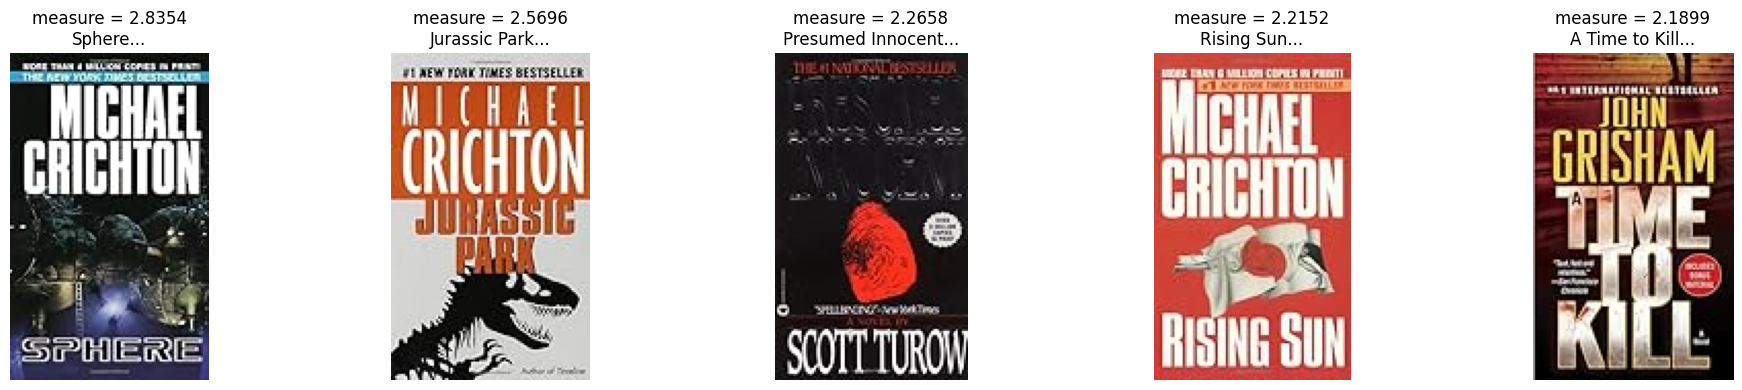

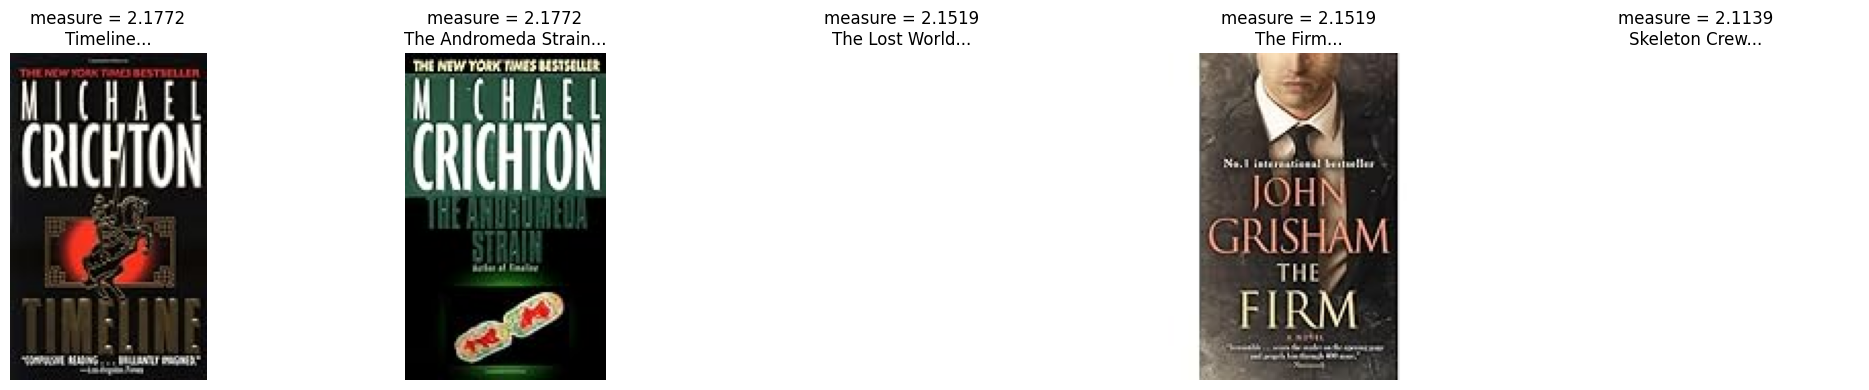

In [28]:
model.user_based(4)

For these items:


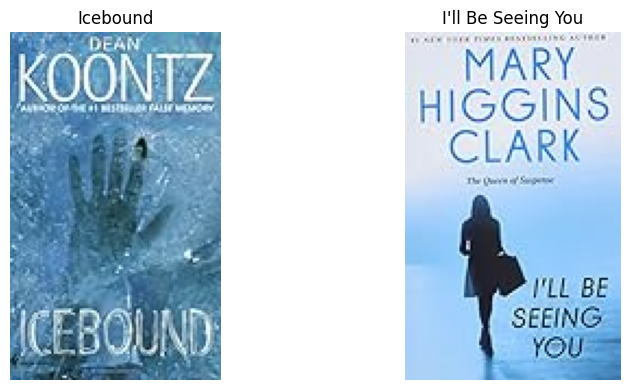

Such recommendations:


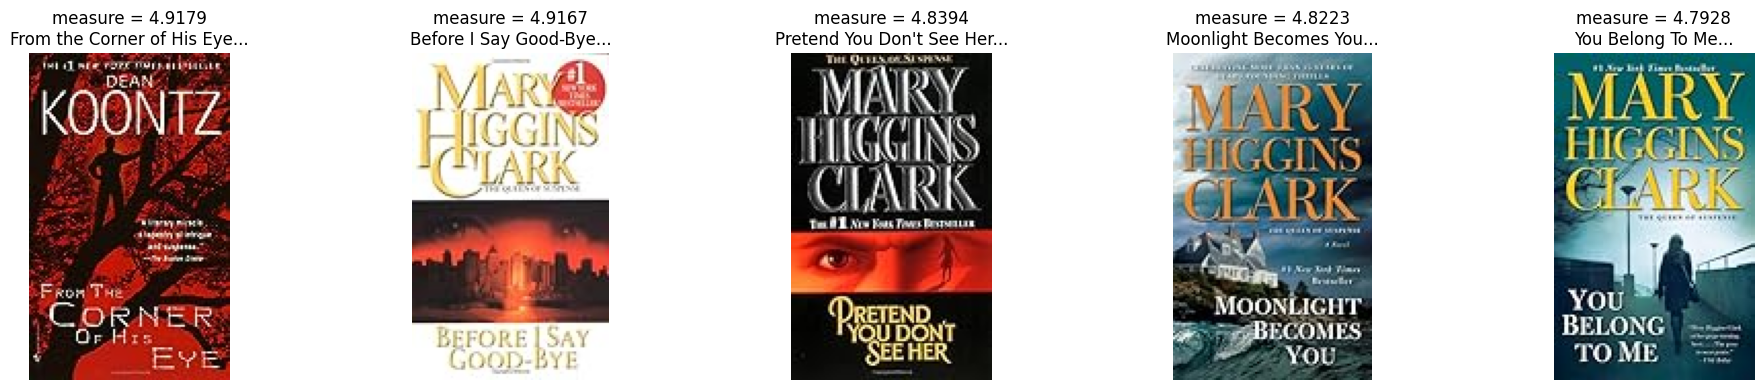

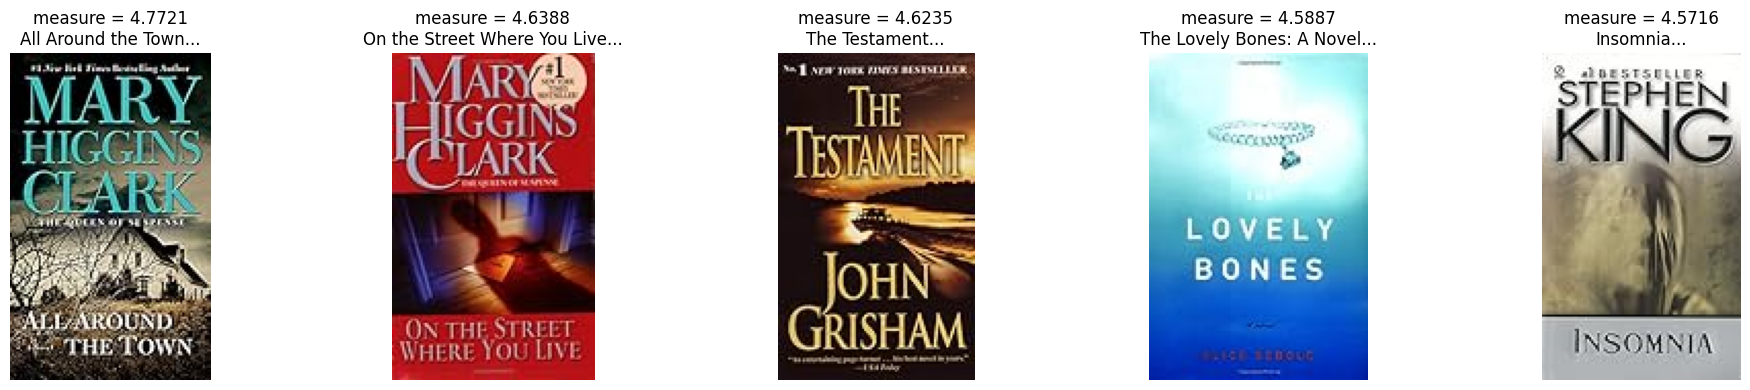

In [29]:
model.user_based(10)

### Item-based

First, let's find some popular books, such as "Harry Potter", "Hobbit".
Then recommendations are checked.

In [24]:
(
    model.interactions
    [model.interactions["item_name"].str.contains("The Lord of the Rings")]
    [["item_id", "item_name"]]
    .drop_duplicates()
    .head(5)
)

item_id                                          item_name
200     71459  The Fellowship of the Ring (The Lord of the Ri...
493     24537     The Two Towers (The Lord of the Rings, Part 2)
1546    71588  The Fellowship of the Ring (The Lord of the Ri...
1973    24547               The Hobbit and The Lord of the Rings
5685    24535  The Hobbit : The Enchanting Prelude to The Lor...

In [25]:
(
    model.interactions
    [model.interactions["item_name"].str.contains("Harry Potter")]
    [["item_id", "item_name"]]
    .drop_duplicates()
    .head(5)
)

item_id                                          item_name
185    46019   Harry Potter and the Chamber of Secrets (Book 2)
186    46020   Harry Potter and the Chamber of Secrets (Book 2)
187    46124  Harry Potter and the Prisoner of Azkaban (Book 3)
188    46125  Harry Potter and the Prisoner of Azkaban (Book 3)
189    46135       Harry Potter and the Goblet of Fire (Book 4)

In [26]:
HARRY_ID = 46425
HOBBIT_ID = 24535

Now let's check item-based recommendations with popular books.

For these items:


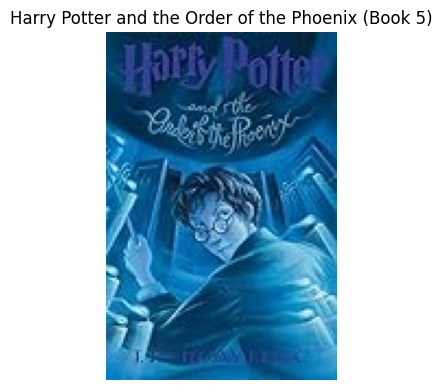

Such recommendations:


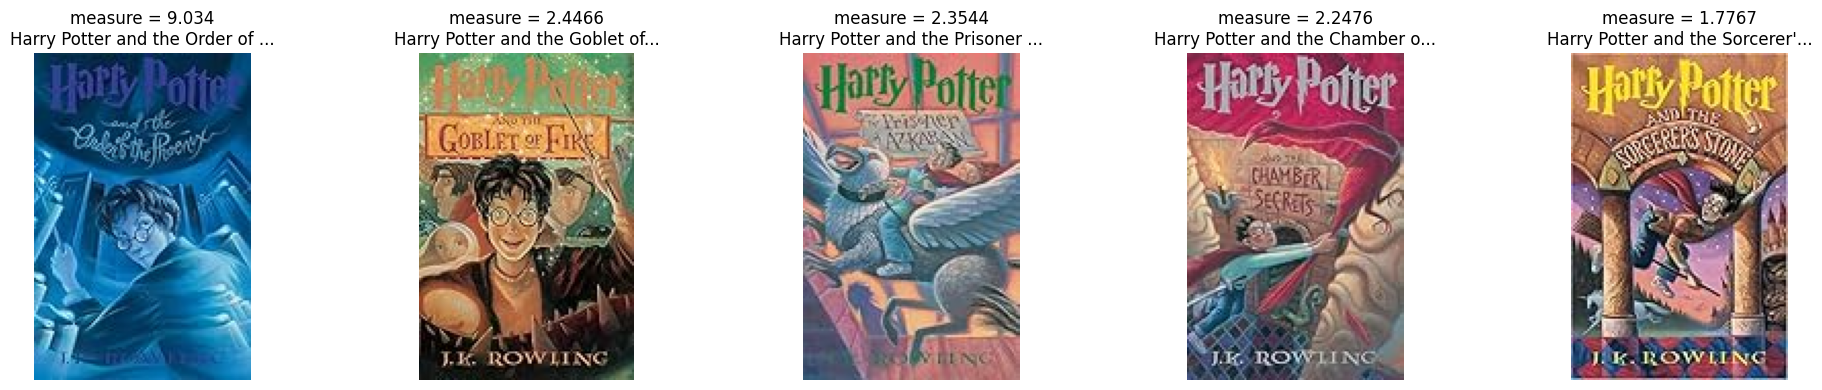

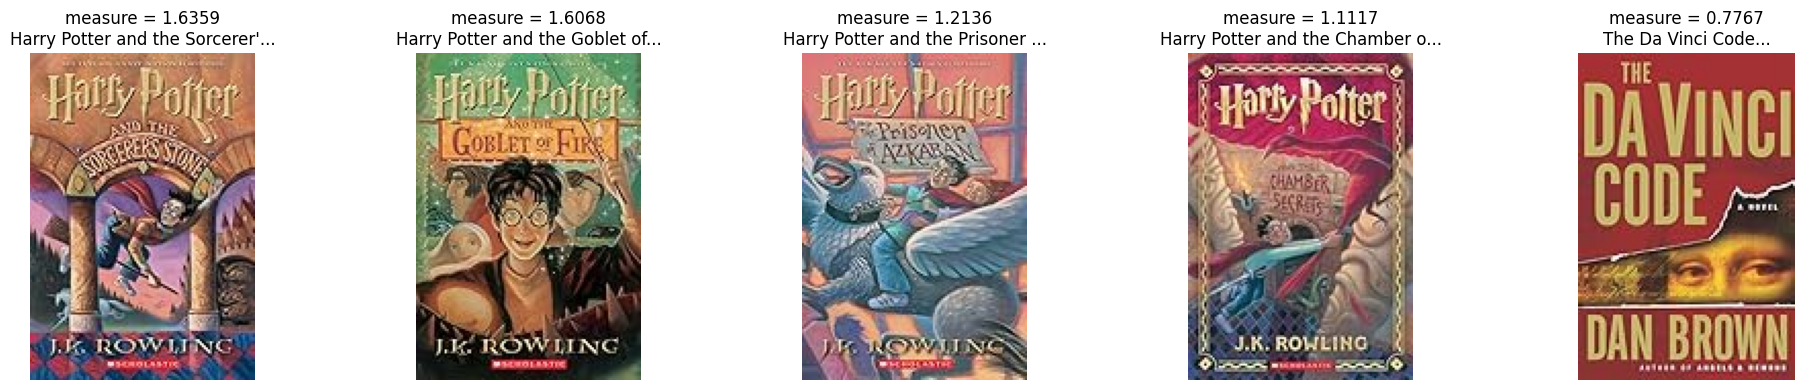

In [27]:
model.adjusted_cosine_item_based(HARRY_ID)

For these items:


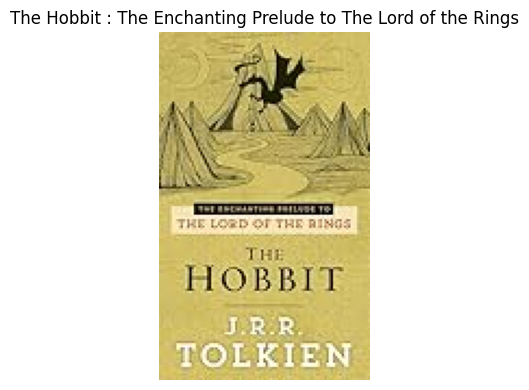

Such recommendations:


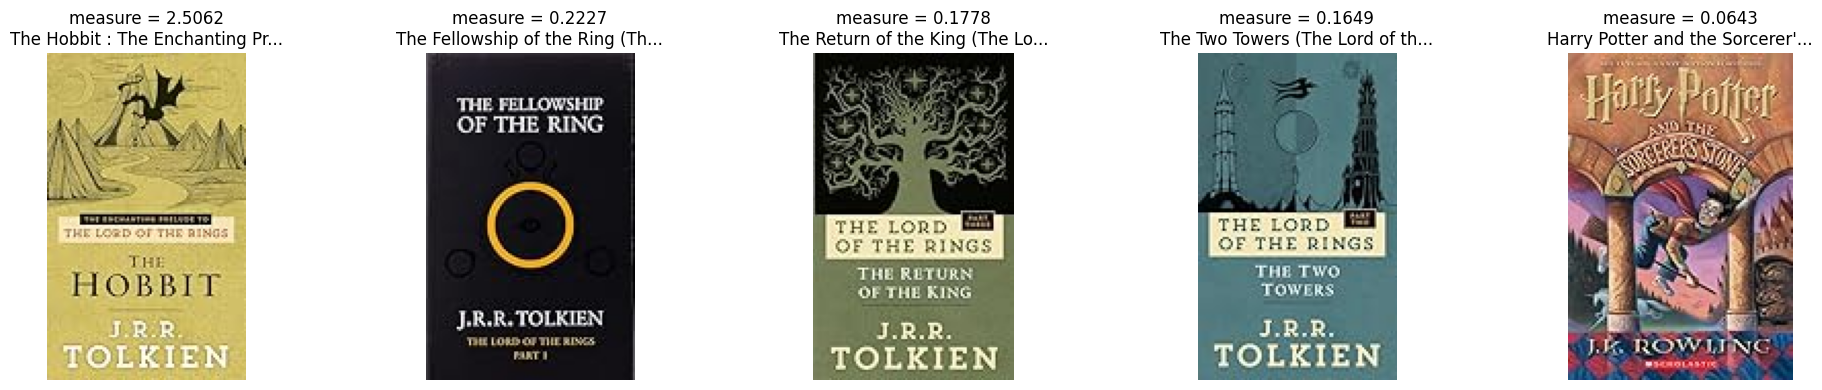

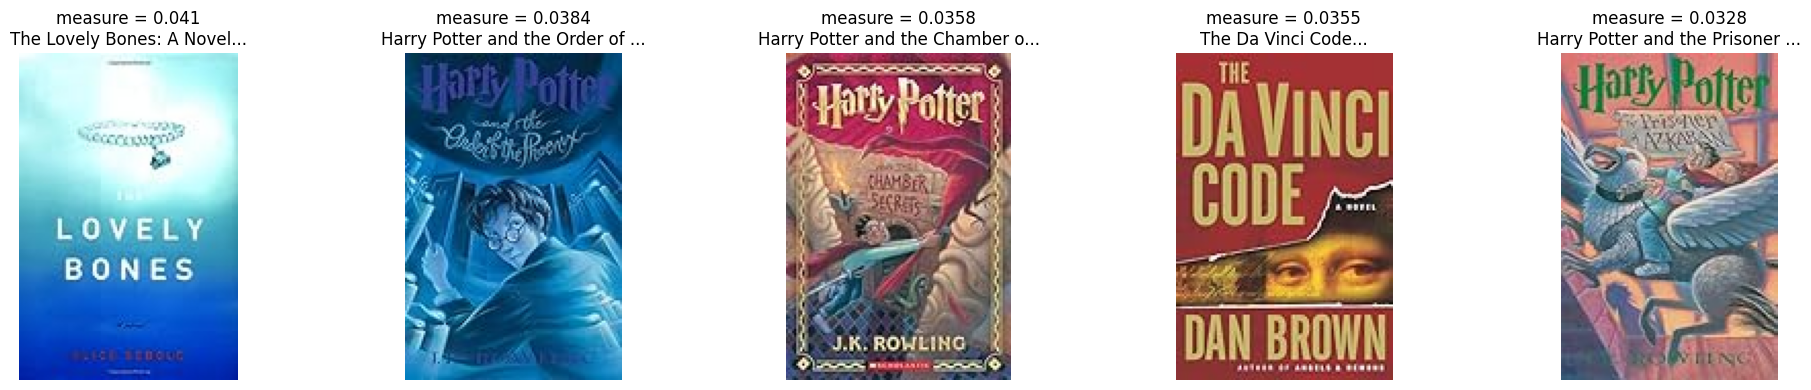

In [28]:
model.cosine_item_based(HOBBIT_ID)